<a href="https://colab.research.google.com/github/mohalhassanmoh/GovJam-2025/blob/main/GovJam_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GovJam-2025
AI prototype for diabetic foot ulcer triage – GovJam 2025 Innovation Challenge

---


# Clone Repository and Move Data Folder
This cell clones the GitHub repository GovJam-2025, moves the data folder directly to /content/, and then removes the original repository folder to keep the workspace clean.

In [1]:
!git clone  https://github.com/mohalhassanmoh/GovJam-2025
!mv /content/GovJam-2025/configs /content/
!mv /content/GovJam-2025/data /content/
!mv /content/GovJam-2025/models /content/
!mv /content/GovJam-2025/reports /content/
!rm -r /content/GovJam-2025

!pip -q install torchmetrics==1.4.0

Cloning into 'GovJam-2025'...
remote: Enumerating objects: 1686, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 1686 (delta 34), reused 29 (delta 1), pack-reused 1592 (from 1)
Receiving objects: 100% (1686/1686), 84.63 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (2286/2286), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.8 MB/s eta 0:00:00


# Build patient-wise splits (70/15/15) from meta_seed.csv → splits.json
This cell loads meta_seed.csv, verifies that all required columns and image paths exist, and then splits patients into 70% training, 15% validation, and 15% test groups. The splits are saved into splits.json to ensure that each patient’s images are assigned to only one set, preventing data leakage.

In [ ]:
# === Build patient-wise splits (70/15/15) from meta_seed.csv → splits.json ===
import json, random
from pathlib import Path
import pandas as pd

SEED = 42
random.seed(SEED)

# Try to find meta_seed.csv in common locations
candidates = [
    Path.cwd() / "data" / "interim" / "meta_seed.csv",
    Path.cwd() / "dfu-triage" / "data" / "interim" / "meta_seed.csv",
    Path("/content/dfu-triage/data/interim/meta_seed.csv"),
    Path("/content/data/interim/meta_seed.csv"),
]
META_CSV = next((p for p in candidates if p.exists()), None)
assert META_CSV is not None, "meta_seed.csv not found. Check the path."

# Set ROOT to the directory that contains the data/ folder
ROOT = META_CSV.parents[2]
SPLITS_JSON = ROOT / "data" / "interim" / "splits.json"

print("ROOT:", ROOT.as_posix())
print("META:", META_CSV.as_posix())
print("SPLITS:", SPLITS_JSON.as_posix())

# Read data
df = pd.read_csv(META_CSV)

# Verify required columns
required_cols = {"image_path", "label", "patient_id"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing columns in meta_seed.csv: {missing}"

# Confirm paths actually exist
def exists_rel(rel: str) -> bool:
    return (ROOT / Path(rel)).exists()

df["__exists"] = df["image_path"].astype(str).apply(exists_rel)
if not df["__exists"].all():
    missing_paths = df.loc[~df["__exists"], "image_path"].tolist()
    raise FileNotFoundError(
        f"Some paths do not exist (count={len(missing_paths)}). Examples:\n" +
        "\n".join(missing_paths[:10])
    )
df = df.drop(columns="__exists")

# Get patient list and distribute 70/15/15
patients = df["patient_id"].astype(str).unique().tolist()
random.shuffle(patients)

train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15
n_pat = len(patients)
n_train = int(round(n_pat * train_ratio))
n_val   = int(round(n_pat * val_ratio))
n_test  = n_pat - n_train - n_val

train_p = patients[:n_train]
val_p   = patients[n_train:n_train+n_val]
test_p  = patients[n_train+n_val:]

def rows_for(pids):
    return df[df["patient_id"].astype(str).isin(pids)].copy()

df_train = rows_for(train_p)
df_val   = rows_for(val_p)
df_test  = rows_for(test_p)

# Summary
counts = {
    "patients": {"total": n_pat, "train": len(train_p), "val": len(val_p), "test": len(test_p)},
    "images":   {"total": len(df), "train": len(df_train), "val": len(df_val), "test": len(df_test)},
    "labels":   {
        "train": df_train["label"].value_counts().to_dict(),
        "val":   df_val["label"].value_counts().to_dict(),
        "test":  df_test["label"].value_counts().to_dict(),
    }
}

def to_list(dframe):
    return dframe[["image_path","label","patient_id"]].to_dict(orient="records")

splits = {
    "seed": SEED,
    "ratios": {"train": train_ratio, "val": val_ratio, "test": test_ratio},
    "counts": counts,
    "by_patient": {
        "train": sorted(set(train_p)),
        "val":   sorted(set(val_p)),
        "test":  sorted(set(test_p)),
    },
    "splits": {
        "train": to_list(df_train),
        "val":   to_list(df_val),
        "test":  to_list(df_test),
    }
}

SPLITS_JSON.parent.mkdir(parents=True, exist_ok=True)
with open(SPLITS_JSON, "w", encoding="utf-8") as f:
    json.dump(splits, f, ensure_ascii=False, indent=2)

print("\n✅ Split created and saved to:", SPLITS_JSON.as_posix())
print(json.dumps(counts, ensure_ascii=False, indent=2))


ROOT: /content
META: /content/data/interim/meta_seed.csv
SPLITS: /content/data/interim/splits.json

✅ Split created and saved to: /content/data/interim/splits.json
{
  "patients": {
    "total": 1055,
    "train": 738,
    "val": 158,
    "test": 159
  },
  "images": {
    "total": 1055,
    "train": 738,
    "val": 158,
    "test": 159
  },
  "labels": {
    "train": {
      "0": 379,
      "1": 359
    },
    "val": {
      "1": 80,
      "0": 78
    },
    "test": {
      "0": 86,
      "1": 73
    }
  }
}


#Preprocess Images into Patient-Wise Splits (Letterbox to 512×512, JPEG)
This cell reads meta_seed.csv and splits.json, then preprocesses all images into data/processed/ according to the patient-wise splits (train/val/test). Each image is:

* EXIF-rotated, converted to RGB, and letterboxed to a 512×512 square (keepingaspect ratio, padding with PAD_COLOR).

* Saved as optimized JPEG (quality=95) under class folders: healthy or ulcer.

* Named as originalStem__patientId.jpg to ensure uniqueness.
It also writes a processed_meta.csv with source/processed paths and prints quick counts per split/class.


In [ ]:
# === Preprocess images to data/processed/ (patient-wise splits) ===
import json, os, hashlib
from pathlib import Path
from PIL import Image, ImageOps
import pandas as pd
from tqdm import tqdm

# General settings
SIZE = 512
JPEG_QUALITY = 95
PAD_COLOR = (0, 0, 0)   # Padding background black (you can switch to (255,255,255) if you prefer)

ROOT = Path.cwd()  # Make sure you are inside dfu-triage/
META_CSV    = ROOT / "data" / "interim" / "meta_seed.csv"
SPLITS_JSON = ROOT / "data" / "interim" / "splits.json"

assert META_CSV.exists(),    f"Not found: {META_CSV}"
assert SPLITS_JSON.exists(), f"Not found: {SPLITS_JSON}"

with open(SPLITS_JSON, "r", encoding="utf-8") as f:
    splits = json.load(f)

# Output destinations
PROC_ROOT = ROOT / "data" / "processed"
DESTS = {
    "train": {
        0: PROC_ROOT / "train" / "healthy",
        1: PROC_ROOT / "train" / "ulcer",
    },
    "val": {
        0: PROC_ROOT / "val" / "healthy",
        1: PROC_ROOT / "val" / "ulcer",
    },
    "test": {
        0: PROC_ROOT / "test" / "healthy",
        1: PROC_ROOT / "test" / "ulcer",
    },
}
for split_name, dmap in DESTS.items():
    for lbl, ddir in dmap.items():
        ddir.mkdir(parents=True, exist_ok=True)

# Resize with aspect ratio preserved (letterbox to a SIZE×SIZE square)
def letterbox_to_square(img: Image.Image, size=512, pad_color=(0,0,0)):
    img = ImageOps.exif_transpose(img)       # Fix EXIF orientation
    img = img.convert("RGB")                  # Ensure RGB
    w, h = img.size
    scale = min(size / w, size / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    img_resized = img.resize((nw, nh), Image.BICUBIC)

    canvas = Image.new("RGB", (size, size), pad_color)
    offset = ((size - nw) // 2, (size - nh) // 2)
    canvas.paste(img_resized, offset)
    return canvas

# Load original metadata
meta_df = pd.read_csv(META_CSV)
meta_df["image_path"] = meta_df["image_path"].astype(str)

# Helper: process and save for a given record
def process_and_save(rec, split_name):
    rel = rec["image_path"]
    lbl = int(rec["label"])
    pid = str(rec["patient_id"])

    src_path = ROOT / Path(rel)
    assert src_path.exists(), f"Image not found: {src_path}"

    # Destination filename: keep original name and append pid to ensure uniqueness
    stem = src_path.stem
    dest_dir = DESTS[split_name][lbl]
    dest_name = f"{stem}__{pid}.jpg"
    dest_path = dest_dir / dest_name

    # Processing
    with Image.open(src_path) as im:
        out = letterbox_to_square(im, size=SIZE, pad_color=PAD_COLOR)
        out.save(dest_path, format="JPEG", quality=JPEG_QUALITY, optimize=True)

    return dest_path

# Build output dataframe
rows_out = []

for split_name in ["train", "val", "test"]:
    recs = splits["splits"][split_name]
    print(f"⏳ Processing split: {split_name} (num images: {len(recs)})")
    for rec in tqdm(recs):
        dest_path = process_and_save(rec, split_name)
        rows_out.append({
            "split": split_name,
            "label": int(rec["label"]),
            "patient_id": str(rec["patient_id"]),
            "src_image_path": rec["image_path"],
            "proc_image_path": dest_path.relative_to(ROOT).as_posix()
        })

# Save processed metadata
processed_meta = pd.DataFrame(rows_out)
out_meta_csv = ROOT / "data" / "interim" / "processed_meta.csv"
processed_meta.to_csv(out_meta_csv, index=False, encoding="utf-8")

# Quick stats
def count_dir(p: Path):
    if not p.exists(): return 0
    return sum(1 for _ in p.glob("*.jpg"))

stats = {
    "train_healthy": count_dir(DESTS["train"][0]),
    "train_ulcer":   count_dir(DESTS["train"][1]),
    "val_healthy":   count_dir(DESTS["val"][0]),
    "val_ulcer":     count_dir(DESTS["val"][1]),
    "test_healthy":  count_dir(DESTS["test"][0]),
    "test_ulcer":    count_dir(DESTS["test"][1]),
}

print("\n✅ Images prepared in data/processed/")
for k,v in stats.items():
    print(f"{k:>14}: {v}")

print("\n🔎 Processed images metadata saved to:", out_meta_csv.as_posix())
print(processed_meta.head(8).to_string(index=False))


⏳ Processing split: train (num images: 738)


100%|██████████| 738/738 [00:11<00:00, 62.65it/s] 


⏳ Processing split: val (num images: 158)


100%|██████████| 158/158 [00:02<00:00, 58.97it/s]


⏳ Processing split: test (num images: 159)


100%|██████████| 159/159 [00:02<00:00, 55.87it/s]


✅ Images prepared in data/processed/
 train_healthy: 379
   train_ulcer: 359
   val_healthy: 78
     val_ulcer: 80
  test_healthy: 86
    test_ulcer: 73

🔎 Processed images metadata saved to: /content/data/interim/processed_meta.csv
split  label patient_id                          src_image_path                                    proc_image_path
train      0       H002 data/raw/images/healthy/healthy_002.jpg data/processed/train/healthy/healthy_002__H002.jpg
train      0       H003 data/raw/images/healthy/healthy_003.jpg data/processed/train/healthy/healthy_003__H003.jpg
train      0       H005 data/raw/images/healthy/healthy_005.jpg data/processed/train/healthy/healthy_005__H005.jpg
train      0       H006 data/raw/images/healthy/healthy_006.jpg data/processed/train/healthy/healthy_006__H006.jpg
train      0       H007 data/raw/images/healthy/healthy_007.jpg data/processed/train/healthy/healthy_007__H007.jpg
train      0       H009 data/raw/images/healthy/healthy_009.jpg data/process

# Train EfficientNet-B0 on Preprocessed Data with AUROC-Based Checkpointing
This cell prepares PyTorch dataloaders from data/processed/ (train/val/test), builds an EfficientNet-B0 model pre-trained on ImageNet, replaces the final layer for binary output, and trains with BCEWithLogitsLoss using AdamW and a CosineAnnealingLR scheduler.
It uses mixed-precision (AMP) on GPU for speed/memory efficiency. After each epoch, it computes validation AUROC (via torchmetrics) and saves a checkpoint whenever AUROC improves. The best model path and score are printed at the end.

In [ ]:
# === Train EfficientNet-B0 on data/processed with AUROC checkpoint ===

import os, math, time
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAUROC
import numpy as np
from tqdm import tqdm

ROOT = Path("/content")  # per your previous outputs
DATA_DIR = ROOT / "data" / "processed"
MODEL_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
for p in [MODEL_DIR, REPORTS_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Transforms (images are already 512×512; apply Normalize)
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    normalize,
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_ds = datasets.ImageFolder((DATA_DIR / "train").as_posix(), transform=train_tfms)
val_ds   = datasets.ImageFolder((DATA_DIR / "val").as_posix(),   transform=val_tfms)
test_ds  = datasets.ImageFolder((DATA_DIR / "test").as_posix(),  transform=val_tfms)

BATCH_SIZE = 16
NUM_WORKERS = 2
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# EfficientNet-B0 from torchvision (pretrained on ImageNet)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)  # single output (binary)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

EPOCHS = 20
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

best_auroc = -1.0
best_path = MODEL_DIR / "baseline_efficientnet_b0.pth"

def evaluate_auroc(dataloader):
    model.eval()
    auroc = BinaryAUROC(thresholds=None).to(device)
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).float()
            logits = model(x).squeeze(1)
            auroc.update(torch.sigmoid(logits), y)
    return auroc.compute().item()

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss, n = 0.0, 0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x).squeeze(1)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item() * x.size(0)
        n += x.size(0)
        pbar.set_postfix(loss=f"{(epoch_loss/n):.4f}")

    val_auroc = evaluate_auroc(val_dl)
    scheduler.step()

    print(f"Val AUROC: {val_auroc:.4f}")
    if val_auroc > best_auroc:
        best_auroc = val_auroc
        torch.save({
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "val_auroc": best_auroc,
        }, best_path)
        print(f"✅ Saved new best model → {best_path.name} (AUROC={best_auroc:.4f})")

print(f"\n🏁 Best Val AUROC: {best_auroc:.4f} | Checkpoint: {best_path}")


Device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 198MB/s]
/tmp/ipython-input-1287055682.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
Epoch 1/20:   0%|          | 0/47 [00:00<?, ?it/s]/tmp/ipython-input-1287055682.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 1/20: 100%|██████████| 47/47 [00:35<00:00,  1.34it/s, loss=0.1924]


Val AUROC: 0.9976
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=0.9976)


Epoch 2/20: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s, loss=0.0765]


Val AUROC: 0.9994
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=0.9994)


Epoch 3/20: 100%|██████████| 47/47 [00:20<00:00,  2.34it/s, loss=0.0537]


Val AUROC: 0.9994
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=0.9994)


Epoch 4/20: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s, loss=0.0450]


Val AUROC: 0.9989


Epoch 5/20: 100%|██████████| 47/47 [00:13<00:00,  3.57it/s, loss=0.0174]


Val AUROC: 0.9971


Epoch 6/20: 100%|██████████| 47/47 [00:15<00:00,  2.95it/s, loss=0.0084]


Val AUROC: 0.9976


Epoch 7/20: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s, loss=0.0100]


Val AUROC: 0.9995
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=0.9995)


Epoch 8/20: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s, loss=0.0143]


Val AUROC: 0.9998
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=0.9998)


Epoch 9/20: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s, loss=0.0131]


Val AUROC: 0.9997


Epoch 10/20: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.0060]


Val AUROC: 1.0000
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=1.0000)


Epoch 11/20: 100%|██████████| 47/47 [00:16<00:00,  2.81it/s, loss=0.0480]


Val AUROC: 0.9989


Epoch 12/20: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s, loss=0.0154]


Val AUROC: 1.0000
✅ Saved new best model → baseline_efficientnet_b0.pth (AUROC=1.0000)


Epoch 13/20: 100%|██████████| 47/47 [00:12<00:00,  3.65it/s, loss=0.0113]


Val AUROC: 0.9994


Epoch 14/20: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s, loss=0.0051]


Val AUROC: 0.9995


Epoch 15/20: 100%|██████████| 47/47 [00:16<00:00,  2.78it/s, loss=0.0071]


Val AUROC: 0.9998


Epoch 16/20: 100%|██████████| 47/47 [00:14<00:00,  3.33it/s, loss=0.0037]


Val AUROC: 1.0000


Epoch 17/20: 100%|██████████| 47/47 [00:13<00:00,  3.53it/s, loss=0.0082]


Val AUROC: 1.0000


Epoch 18/20: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s, loss=0.0094]


Val AUROC: 1.0000


Epoch 19/20: 100%|██████████| 47/47 [00:13<00:00,  3.48it/s, loss=0.0027]


Val AUROC: 1.0000


Epoch 20/20: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s, loss=0.0083]


Val AUROC: 1.0000

🏁 Best Val AUROC: 1.0000 | Checkpoint: /content/models/baseline_efficientnet_b0.pth


# Evaluate Best Checkpoint: ROC, PR, Confusion Matrix, and Test Predictions CSV

This cell loads the best EfficientNet-B0 checkpoint, builds validation/test dataloaders, and computes key metrics:  
- **ROC curve & AUC** and **Precision–Recall curve & AUC** (on the validation set), saving plots to `reports/figures/roc_val.png` and `reports/figures/pr_val.png`.  
- **Confusion Matrix** at a default threshold of **0.5**, saved as `reports/cm_val.csv`, plus a detailed `reports/classification_report_val.json`.  
- Runs inference on the **test** split and saves per-sample probabilities and 0.5-threshold predictions to `reports/predictions_test.csv`.  
At the end, it also **displays** the saved ROC and PR images inline in the notebook.

✅ ROC (val): 1.000 | PR (val): 1.000
Confusion Matrix (val):
                  Pred_0  Pred_1
True_healthy(0)      78       0
True_ulcer(1)         3      77

🔎 Saved test predictions CSV → /content/reports/predictions_test.csv

📊 Saved figures:
 - /content/reports/figures/roc_val.png
 - /content/reports/figures/pr_val.png
 - /content/reports/cm_val.csv


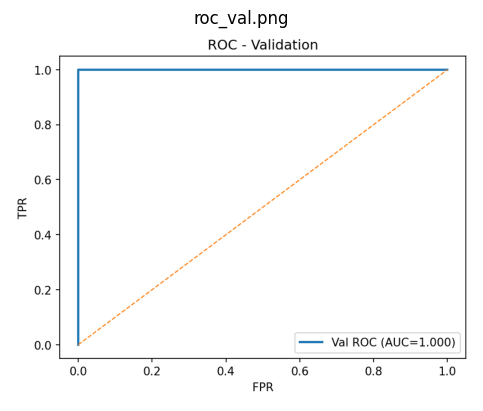

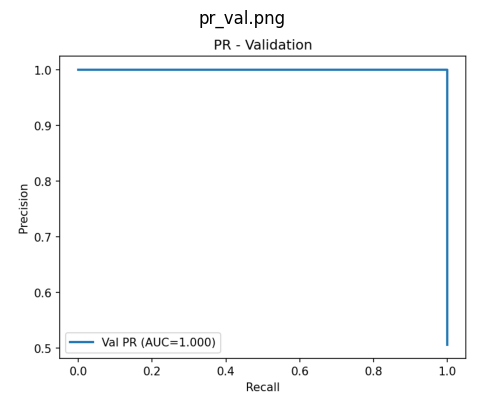

In [ ]:
# === Evaluate best model: ROC, PR, Confusion Matrix + CSV of predictions ===
import torch, json
from pathlib import Path
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd

ROOT = Path("/content")
DATA_DIR = ROOT / "data" / "processed"
MODEL_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluation transforms
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
val_tfms = transforms.Compose([transforms.ToTensor(), normalize])

val_ds  = datasets.ImageFolder((DATA_DIR / "val").as_posix(),  transform=val_tfms)
test_ds = datasets.ImageFolder((DATA_DIR / "test").as_posix(), transform=val_tfms)
val_dl  = DataLoader(val_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Restore best model
ckpt_path = MODEL_DIR / "baseline_efficientnet_b0.pth"
assert ckpt_path.exists(), f"Saved model not found: {ckpt_path}"

model = models.efficientnet_b0(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, 1)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["state_dict"])
model = model.to(device)
model.eval()

def predict_dl(dataloader):
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(y.numpy().tolist())
    return np.array(all_probs), np.array(all_labels)

# Evaluate on VAL
val_probs, val_y = predict_dl(val_dl)
fpr, tpr, _ = roc_curve(val_y, val_probs)
val_roc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(val_y, val_probs)
val_pr = auc(rec, prec)

# Initial threshold 0.5 (can calibrate later)
val_pred05 = (val_probs >= 0.5).astype(int)
cm_val = confusion_matrix(val_y, val_pred05)
report_val = classification_report(val_y, val_pred05, digits=3, output_dict=True)

# Figures
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"Val ROC (AUC={val_roc:.3f})")
plt.plot([0,1],[0,1],'--',lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Validation"); plt.legend()
plt.savefig(FIG_DIR / "roc_val.png", dpi=150, bbox_inches="tight"); plt.close()

plt.figure()
plt.plot(rec, prec, lw=2, label=f"Val PR (AUC={val_pr:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR - Validation"); plt.legend()
plt.savefig(FIG_DIR / "pr_val.png", dpi=150, bbox_inches="tight"); plt.close()

# Confusion Matrix (save as CSV)
cm_df = pd.DataFrame(cm_val, index=["True_healthy(0)","True_ulcer(1)"], columns=["Pred_0","Pred_1"])
cm_df.to_csv(REPORTS_DIR / "cm_val.csv", index=True)

# Text report
with open(REPORTS_DIR / "classification_report_val.json", "w", encoding="utf-8") as f:
    json.dump(report_val, f, ensure_ascii=False, indent=2)

print(f"✅ ROC (val): {val_roc:.3f} | PR (val): {val_pr:.3f}")
print("Confusion Matrix (val):\n", cm_df)

# Test predictions + save CSV
test_probs, test_y = predict_dl(test_dl)
test_pred05 = (test_probs >= 0.5).astype(int)

pred_df = pd.DataFrame({
    "split": "test",
    "prob_ulcer": test_probs,
    "y_true": test_y,
    "y_pred_0p5": test_pred05
})
pred_csv = REPORTS_DIR / "predictions_test.csv"
pred_df.to_csv(pred_csv, index=False)
print("\n🔎 Saved test predictions CSV →", pred_csv.as_posix())

print("\n📊 Saved figures:")
print(" -", (FIG_DIR / "roc_val.png").as_posix())
print(" -", (FIG_DIR / "pr_val.png").as_posix())
print(" -", (REPORTS_DIR / "cm_val.csv").as_posix())

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for p in ["/content/reports/figures/roc_val.png", "/content/reports/figures/pr_val.png"]:
    if os.path.exists(p):
        img = mpimg.imread(p)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(p))
        plt.show()
    else:
        print(f"⚠️ File not found: {p}")


# Calibration with Temperature Scaling & Selecting τ1/τ2 from Validation
This cell loads the best EfficientNet-B0 checkpoint and a **validation** dataloader, then:
- **Collects raw logits** and labels on the validation set.
- Fits a **temperature scalar T** (Temperature Scaling) by minimizing **BCEWithLogitsLoss** via **LBFGS**, producing calibrated probabilities `sigmoid(logits / T)`.
- **Sweeps thresholds** from 0.01→0.99 to compute precision, recall, F1, FPR/TPR, and **Youden’s J = TPR − FPR**.
- Chooses **τ2 (Med/High)** as the **smallest threshold** achieving **Recall ≥ 0.95** with **maximum F1** within that region (fallback: highest-recall threshold if 0.95 is unreachable).
- Chooses **τ1 (Low/Med)** as the threshold that **maximizes Youden’s J**, creating a clean split between low risk and (medium/high).
- Saves the results to:
  - `configs/thresholds.yaml` → `{ temperature T, tau1, tau2, target_recall }`
  - `reports/thresholds_val_summary.json` → metrics at τ1 and τ2 for quick audit.


In [3]:
# === Calibration (Temperature Scaling) + choose τ1/τ2 from Validation ===
import os, yaml, json
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve

ROOT = Path("/content")
DATA_DIR = ROOT / "data" / "processed"
MODEL_DIR = ROOT / "models"
CONFIG_DIR = ROOT / "configs"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
for p in [CONFIG_DIR, REPORTS_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load best model ---
ckpt_path = MODEL_DIR / "baseline_efficientnet_b0.pth"
assert ckpt_path.exists(), f"Saved model not found: {ckpt_path}"
model = models.efficientnet_b0(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["state_dict"])
model = model.to(device).eval()

# --- Val loader (no augmentation) ---
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
val_tfms = transforms.Compose([transforms.ToTensor(), normalize])
val_ds = datasets.ImageFolder((DATA_DIR / "val").as_posix(), transform=val_tfms)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- Collect logits & labels on Val ---
all_logits, all_y = [], []
with torch.no_grad():
    for x, y in val_dl:
        x = x.to(device)
        logits = model(x).squeeze(1).detach().cpu().numpy()
        all_logits.append(logits)
        all_y.append(y.numpy())
all_logits = np.concatenate(all_logits)
all_y = np.concatenate(all_y).astype(int)

# --- Temperature scaling: fit scalar T to minimize BCEWithLogits on logits/T ---
logits_t = torch.tensor(all_logits, dtype=torch.float32, device=device)
y_t = torch.tensor(all_y, dtype=torch.float32, device=device)
T = torch.nn.Parameter(torch.tensor(1.0, device=device))
optimizer = torch.optim.LBFGS([T], lr=0.1, max_iter=50, line_search_fn="strong_wolfe")
criterion = torch.nn.BCEWithLogitsLoss()

def closure():
    optimizer.zero_grad()
    loss = criterion(logits_t / T.clamp_min(1e-3), y_t)
    loss.backward()
    return loss

_ = optimizer.step(closure)
T_opt = float(T.detach().cpu().item())
T_opt = max(T_opt, 1e-3)
print(f"✅ Estimated Temperature T = {T_opt:.4f}")

# Calibrated probabilities
probs_val = torch.sigmoid(torch.tensor(all_logits / T_opt)).numpy()

# --- Threshold search ---
ths = np.linspace(0.01, 0.99, 99)
target_recall = 0.95

def metrics_at_threshold(p, y, th):
    pred = (p >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2*precision*recall / (precision + recall + 1e-9)
    fpr = fp / (fp + tn + 1e-9)
    tpr = recall
    youden = tpr - fpr
    return dict(th=th, precision=precision, recall=recall, f1=f1, youden=youden)

stats = [metrics_at_threshold(probs_val, all_y, th) for th in ths]

# τ2: smallest threshold achieving Recall>=0.95, breaking ties by highest F1 then smaller th
candidates = [s for s in stats if s["recall"] >= target_recall]
if candidates:
    max_f1 = max(c["f1"] for c in candidates)
    tau2 = min(c["th"] for c in candidates if abs(c["f1"] - max_f1) < 1e-9)
else:
    # If 0.95 recall is unreachable, pick threshold with highest recall
    tau2 = max(stats, key=lambda s: s["recall"])["th"]

# τ1: threshold maximizing Youden's J (TPR - FPR) — boundary between Low vs (Med/High)
tau1 = max(stats, key=lambda s: s["youden"])["th"]

print(f"📏 Suggested thresholds → τ1 (Low/Med) = {tau1:.3f} | τ2 (Med/High) = {tau2:.3f}")

# Save to configs/thresholds.yaml
out_cfg = {
    "temperature": T_opt,
    "thresholds": {
        "tau1_low_med": float(round(tau1, 4)),
        "tau2_med_high": float(round(tau2, 4)),
        "target_recall_high": target_recall
    }
}
with open(CONFIG_DIR / "thresholds.yaml", "w", encoding="utf-8") as f:
    yaml.dump(out_cfg, f, allow_unicode=True, sort_keys=False)

# Brief performance summary at τ1 and τ2
def dump_at(th):
    m = metrics_at_threshold(probs_val, all_y, th)
    return {k: (float(v) if isinstance(v, (int,float,np.floating)) else v) for k,v in m.items()}

recap = {
    "val_metrics_at_tau1": dump_at(tau1),
    "val_metrics_at_tau2": dump_at(tau2),
}
with open(REPORTS_DIR / "thresholds_val_summary.json", "w", encoding="utf-8") as f:
    json.dump(recap, f, ensure_ascii=False, indent=2)

print("✅ Saved thresholds →", (CONFIG_DIR / "thresholds.yaml").as_posix())
print(json.dumps(recap, ensure_ascii=False, indent=2))


✅ Estimated Temperature T = 0.4397
📏 Suggested thresholds → τ1 (Low/Med) = 0.130 | τ2 (Med/High) = 0.130
✅ Saved thresholds → /content/configs/thresholds.yaml
{
  "val_metrics_at_tau1": {
    "th": 0.13,
    "precision": 0.9999999999875,
    "recall": 0.9999999999875,
    "f1": 0.9999999994875,
    "youden": 0.9999999999875
  },
  "val_metrics_at_tau2": {
    "th": 0.13,
    "precision": 0.9999999999875,
    "recall": 0.9999999999875,
    "f1": 0.9999999994875,
    "youden": 0.9999999999875
  }
}


# Grad-CAM Showcase: 12-Panel Visualization (6 Ulcer + 6 Healthy)
This cell loads the best EfficientNet-B0 checkpoint and visualizes **class evidence** via **Grad-CAM** on the validation set:
- **Hooks** are registered on the last convolutional block (`model.features[-1]`) to capture **feature maps** (forward hook) and **gradients** (backward hook).
- Up to **6 positive (ulcer)** and **6 negative (healthy)** samples are selected from `data/processed/val`.
- For each image, it computes the Grad-CAM heatmap by **global-average-pooling the gradients** over spatial dims to get channel weights, then forms the CAM and **normalizes** it.
- The CAM is **resized** to image size and **overlaid** on the RGB image with a color map, producing a **side-by-side (raw | CAM)** composite.
- All composites are arranged in a grid and saved to `reports/figures/gradcam_samples.png`, then displayed inline.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Saved Grad-CAM panel → /content/reports/figures/gradcam_samples.png


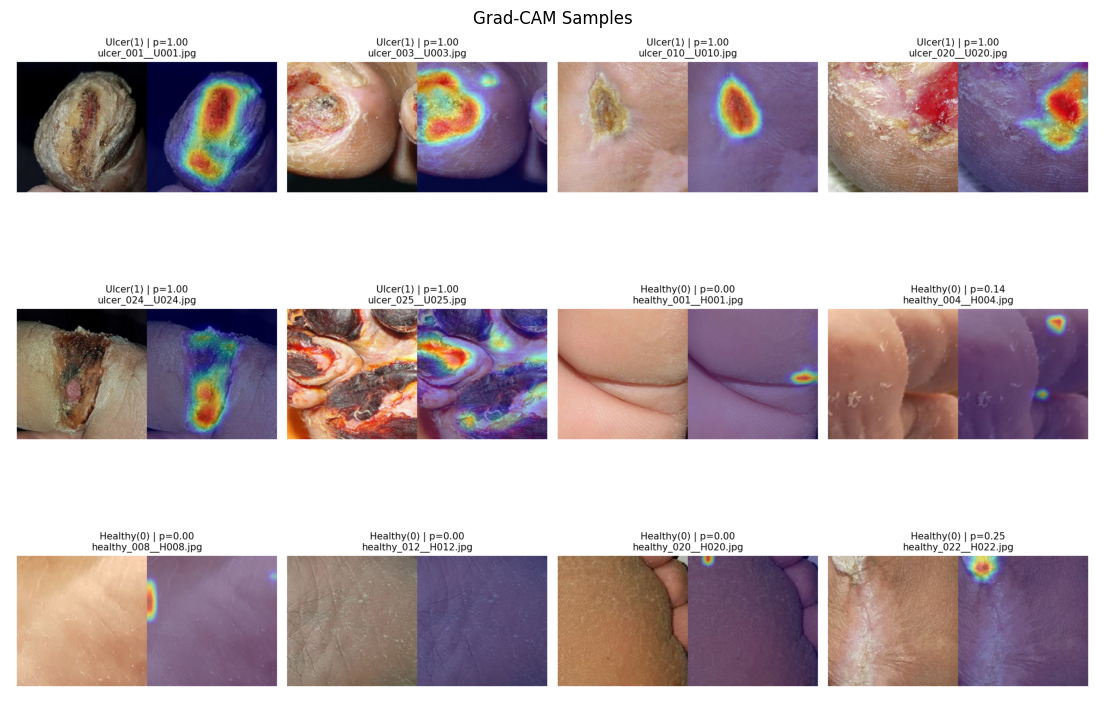

In [4]:
# === Grad-CAM showcase: save a 12-panel figure (6 ulcer + 6 healthy) ===
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from PIL import Image

ROOT = Path("/content")
DATA_DIR = ROOT / "data" / "processed"
MODEL_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- load model ---
ckpt_path = MODEL_DIR / "baseline_efficientnet_b0.pth"
assert ckpt_path.exists(), f"Saved model not found: {ckpt_path}"
model = models.efficientnet_b0(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["state_dict"])
model = model.to(device).eval()

# we'll hook the last conv block: model.features[-1]
target_layer = model.features[-1]
feat_maps = None
grads = None

def fwd_hook(module, input, output):
    global feat_maps
    feat_maps = output.detach()

def bwd_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0].detach()

target_layer.register_forward_hook(fwd_hook)
target_layer.register_backward_hook(bwd_hook)

# data (use processed images; we'll also load raw image for nice overlay)
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
val_tfms = transforms.Compose([transforms.ToTensor(), normalize])
val_ds = datasets.ImageFolder((DATA_DIR / "val").as_posix(), transform=val_tfms)
# keep original paths for pretty overlay
val_paths = [p for p,_ in val_ds.samples]
val_labels = [y for _,y in val_ds.samples]  # 0 healthy, 1 ulcer

# select up to 6 positives and 6 negatives
pos_idx = [i for i,y in enumerate(val_labels) if y==1][:6]
neg_idx = [i for i,y in enumerate(val_labels) if y==0][:6]
chosen_idx = pos_idx + neg_idx
if len(chosen_idx) == 0:
    raise RuntimeError("No samples in Val! Check your data.")

def load_tensor(idx):
    # dataset returns transformed tensor
    x, y = val_ds[idx]
    return x.unsqueeze(0).to(device), y

def gradcam_for_idx(idx):
    global feat_maps, grads
    feat_maps = grads = None
    x, y = load_tensor(idx)
    x.requires_grad_(True)
    # forward
    logits = model(x).squeeze(1)
    prob = torch.sigmoid(logits).item()
    # backward wrt positive class logit
    model.zero_grad(set_to_none=True)
    logits.backward(torch.ones_like(logits))

    # compute CAM
    fmap = feat_maps  # [B,C,H,W]
    grad = grads      # [B,C,H,W]
    weights = grad.mean(dim=(2,3), keepdim=True)   # GAP over H,W
    cam = (weights * fmap).sum(dim=1, keepdim=False)  # [B,H,W]
    cam = torch.relu(cam)
    cam = cam[0].cpu().numpy()
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # load original processed image (for overlay) in RGB
    img_path = val_paths[idx]
    img_bgr = cv2.imread(img_path)  # BGR
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (0.4*heatmap + 0.6*img_rgb).astype(np.uint8)
    return img_rgb, overlay, prob, y, Path(img_path).name

# build panel
n = len(chosen_idx)
cols = 4
rows = int(np.ceil(n / cols))
plt.figure(figsize=(cols*4, rows*4))

for k, idx in enumerate(chosen_idx, 1):
    img_rgb, overlay, prob, y, name = gradcam_for_idx(idx)
    title = f"{'Ulcer(1)' if y==1 else 'Healthy(0)'} | p={prob:.2f}\n{name}"
    plt.subplot(rows, cols, k)
    # side-by-side small composite: left raw, right cam
    concat = np.concatenate([img_rgb, overlay], axis=1)
    plt.imshow(concat)
    plt.axis('off')
    plt.title(title, fontsize=10)

out_path = FIG_DIR / "gradcam_samples.png"
plt.tight_layout()
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.close()
print("✅ Saved Grad-CAM panel →", out_path.as_posix())


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/reports/figures/gradcam_samples.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.axis("off")
plt.title("Grad-CAM Samples")
plt.show()


# Manual Upload → Inference + Grad-CAM + 512×512 Size Warning
This cell lets you **manually upload** an image in Colab, then:
- **Loads** the best EfficientNet-B0 checkpoint and thresholds (`tau1`, `tau2`) + **temperature T** from `configs/thresholds.yaml` (with safe fallbacks).
- **Letterboxes** any non-512×512 image to **512×512** (keeps aspect ratio with padding), then applies **ImageNet normalization**.
- Runs **inference** → computes **calibrated probability** `sigmoid(logit / T)`; maps it to **LOW / MED / HIGH** using `τ1/τ2`.
- Generates **Grad-CAM** from the last conv layer, **overlays** it on the letterboxed image, and **saves** to `reports/figures/overlay_YYYYMMDD_HHMMSS.jpg`.
- Displays **original vs. Grad-CAM overlay** and prints: `p(ulcer)`, band text, `T`, `τ1`, `τ2`, plus a **Priority Score (0..100)**.


Saving test_007.jpg to test_007.jpg
✅ Uploaded: test_007.jpg
⚠️ Original image size 367×598 is not 512×512. Will letterbox.


/tmp/ipython-input-3505254873.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat = (cm.get_cmap('jet')(np.clip(cam,0,1))[..., :3] * 255).astype(np.uint8)


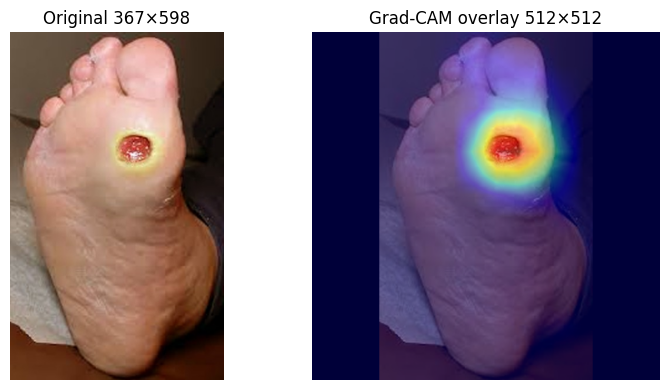


**p(ulcer) = 1.000**
🔴 HIGH risk (≥ τ2=0.13)
T = 0.440 | τ1 = 0.13 | τ2 = 0.13
📁 Saved overlay → /content/reports/figures/overlay_20250919_070645.jpg
🔢 Priority Score = 100.0 / 100
Your thresholds: τ1 = 13.0% | τ2 = 13.0%


In [10]:
# =======================
# Manual upload → Inference + Grad-CAM + Warning if not 512×512
# =======================
!pip -q install pyyaml

import os, time, yaml
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models

# ---------- Paths & constants ----------
ROOT        = Path("/content")
MODEL_PATH  = ROOT / "models"  / "baseline_efficientnet_b0.pth"
CONFIG_PATH = ROOT / "configs" / "thresholds.yaml"
REPORTS_DIR = ROOT / "reports"
FIG_DIR     = REPORTS_DIR / "figures"
for p in [REPORTS_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

IMG_SIZE   = 512
PAD_COLOR  = (0, 0, 0)
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Load model ----------
assert MODEL_PATH.exists(), f"❌ Model not found: {MODEL_PATH}"
model = models.efficientnet_b0(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state["state_dict"])
model.eval().to(device)

# ---------- Load thresholds & temperature (fallbacks if missing) ----------
T_opt = 1.0
tau1, tau2 = 0.40, 0.60
if CONFIG_PATH.exists():
    try:
        cfg = yaml.safe_load(open(CONFIG_PATH, "r", encoding="utf-8"))
        T_opt = float(cfg.get("temperature", 1.0))
        ths   = cfg.get("thresholds", {})
        tau1  = float(ths.get("tau1_low_med", tau1))
        tau2  = float(ths.get("tau2_med_high", tau2))
    except Exception as e:
        print(f"⚠️ Could not read thresholds.yaml: {e}. Using default values.")

# ---------- Utils ----------
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225])
to_tensor = transforms.Compose([transforms.ToTensor(), normalize])

def letterbox_to_square(img: Image.Image, size=IMG_SIZE, pad_color=PAD_COLOR):
    img = ImageOps.exif_transpose(img).convert("RGB")
    w, h = img.size
    scale = min(size / w, size / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    img_resized = img.resize((nw, nh), Image.LANCZOS)
    canvas = Image.new("RGB", (size, size), pad_color)
    offset = ((size - nw) // 2, (size - nh) // 2)
    canvas.paste(img_resized, offset)
    return canvas

def find_last_conv(m: torch.nn.Module):
    last = None
    for _, layer in m.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            last = layer
    return last

LAST_CONV = find_last_conv(model)
assert LAST_CONV is not None, "No Conv layer found for Grad-CAM."

def compute_gradcam_for_logits(model, x_tensor, last_conv):
    acts, grads = [], []

    def fwd_hook(m, i, o): acts.append(o)
    def bwd_hook(m, gin, gout): grads.append(gout[0])

    h1 = last_conv.register_forward_hook(fwd_hook)
    h2 = last_conv.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    logits = model(x_tensor).squeeze(1)   # (1,)
    score = logits[0]
    score.backward(retain_graph=False)

    A = acts[-1].detach()   # (1,C,h,w)
    G = grads[-1].detach()  # (1,C,h,w)
    h1.remove(); h2.remove()

    weights = G.mean(dim=(2,3), keepdim=True)     # (1,C,1,1)
    cam = (weights * A).sum(dim=1, keepdim=True)  # (1,1,h,w)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    if cam.max() > 1e-12:
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-12)
    else:
        cam = np.zeros_like(cam)
    return cam, logits.detach()

def overlay_cam_on_image(img_pil: Image.Image, cam: np.ndarray, alpha=0.45):
    heat = (cm.get_cmap('jet')(np.clip(cam,0,1))[..., :3] * 255).astype(np.uint8)
    heat_img = Image.fromarray(heat).resize(img_pil.size, Image.BICUBIC)
    return Image.blend(img_pil.convert("RGB"), heat_img, alpha)

def triage_from_prob(p: float, t1: float, t2: float):
    if p < t1:
        return "LOW",  f"🟢 Low risk (< τ1={t1:.2f})"
    elif p < t2:
        return "MED",  f"🟡 Medium risk (between τ1={t1:.2f} and τ2={t2:.2f})"
    else:
        return "HIGH", f"🔴 HIGH risk (≥ τ2={t2:.2f})"

# ---------- Pick an image ----------
# Easiest on Colab: upload an image from your device
try:
    from google.colab import files
    uploaded = files.upload()  # pick a local image (JPG/PNG)
    assert len(uploaded) > 0, "No file was uploaded."
    IMG_PATH = list(uploaded.keys())[0]
    print("✅ Uploaded:", IMG_PATH)
except Exception as e:
    # If not on Colab, set a path manually:
    # IMG_PATH = "/path/to/your/image.jpg"
    raise

# ---------- Inference ----------
orig = Image.open(IMG_PATH)
if orig.size != (IMG_SIZE, IMG_SIZE):
    print(f"⚠️ Original image size {orig.size[0]}×{orig.size[1]} is not {IMG_SIZE}×{IMG_SIZE}. Will letterbox.")

letterboxed = letterbox_to_square(orig, size=IMG_SIZE, pad_color=PAD_COLOR)
x = to_tensor(letterboxed).unsqueeze(0).to(device)

# Grad-CAM + logits (requires gradient tracking)
model.zero_grad(set_to_none=True)
cam, logits = compute_gradcam_for_logits(model, x, LAST_CONV)

# Temperature scaling → probability
logit = logits.item()
logit_cal = logit / max(T_opt, 1e-3)
prob = float(torch.sigmoid(torch.tensor(logit_cal)).item())
band, band_txt = triage_from_prob(prob, tau1, tau2)

overlay = overlay_cam_on_image(letterboxed, cam, alpha=0.45)

# ---------- Show & Save ----------
ts = time.strftime("%Y%m%d_%H%M%S")
save_path = FIG_DIR / f"overlay_{ts}.jpg"
overlay.save(save_path)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig);       plt.axis('off'); plt.title(f"Original {orig.size[0]}×{orig.size[1]}")
plt.subplot(1,2,2); plt.imshow(overlay);    plt.axis('off'); plt.title(f"Grad-CAM overlay {IMG_SIZE}×{IMG_SIZE}")
plt.tight_layout(); plt.show()

print(f"\n**p(ulcer) = {prob:.3f}**")
print(band_txt)
print(f"T = {T_opt:.3f} | τ1 = {tau1:.2f} | τ2 = {tau2:.2f}")
print("📁 Saved overlay →", save_path.as_posix())

# === Priority score (0..100) ===
def priority_score(p, decimals=1):
    p = float(max(0.0, min(1.0, p)))     # clamp to [0,1]
    return round(p * 100.0, decimals)

score = priority_score(prob, decimals=1)   # e.g., one decimal place
tau1_pct = round(tau1 * 100.0, 1)
tau2_pct = round(tau2 * 100.0, 1)

print(f"🔢 Priority Score = {score} / 100")
print(f"Your thresholds: τ1 = {tau1_pct}% | τ2 = {tau2_pct}%")


# Update `triage.yaml`: Enforce English Triage Labels + Add Area Estimation, Quality Checks, and Latency Logging

This cell creates/updates `/content/configs/triage.yaml` by:
- **Forcing the `triage` section to English** labels, rules, and advice (overwrites any previous non-English triage content).
- **Preserving your existing config** elsewhere: performs a **deep fill-merge** for other sections so your custom values/paths remain, only missing keys are filled.
- **Adding new sections** if absent:
  - `area_estimation` (CAM-based ulcer area estimation with `cam_topk` percentile),
  - `quality` (image quality gates: size, brightness, blur; action = `reject` or `warn`),
  - `latency` (enable simple latency logging),
  - plus `ui` and `paths` defaults.
- Ensures `model`, `transforms`, `calibration`, and `severity` keys exist with sane defaults.
- Saves the merged result back to `/content/configs/triage.yaml`.


In [6]:
# === Update /content/configs/triage.yaml: enforce English triage labels/texts + add area_estimation, quality, latency ===
import os

# Ensure PyYAML is available
try:
    import yaml
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pyyaml"])
    import yaml

cfg_path = "/content/configs/triage.yaml"
os.makedirs("/content/configs", exist_ok=True)

# ---- English baseline config (we will overwrite ONLY the triage section; other sections are merged additively) ----
base = {
    "model": {
        "ckpt_path": "/content/models/baseline_efficientnet_b0.pth",
        "arch": "efficientnet_b0",
        "positive_is_ulcer": True,
    },
    "transforms": {
        "img_size": 224,
        "mean": [0.485, 0.456, 0.406],
        "std":  [0.229, 0.224, 0.225],
    },
    "calibration": {"T": 0.5402},
    "severity": {"weight_p": 0.7, "weight_area": 0.3},

    # ==== Triage engine (supports "S" or "p_area") ====
    "triage": {
        "mode": "p_area",   # "S" or "p_area"
        "S": {
            "critical": 80, "high": 60, "med": 40,
            "texts": {
                "critical": "Immediate ER referral; surgical/vascular assessment.",
                "high":     "Specialist clinic within 24h; antibiotics/advanced dressing.",
                "med":      "Clinic within 72h; offloading and glycemic control.",
                "low":      "Routine appointment (2–4 weeks); education & prevention.",
            },
        },
        "p_area": {
            "rules": [
                {
                    "label": "ER now",
                    "when":  {"p_ulcer_gte": 0.90, "area_pct_gte": 10},
                    "advice":"Urgent referral; vascular/wound assessment; intensive glycemic control.",
                },
                {
                    "label": "Within 24h",
                    "when":  {"p_ulcer_gte": 0.75, "area_pct_gte": 5},
                    "advice":"Expedited clinic within 24h; antibiotics and advanced dressing.",
                },
                {
                    "label": "Within 72h",
                    "when":  {"p_ulcer_gte": 0.50},
                    "advice":"Clinic within 72h; prevention plan and offloading.",
                },
                {
                    "label": "Routine (2–4 weeks)",
                    "when":  {},
                    "advice":"Routine follow-up; education; footwear/pressure check.",
                },
            ]
        },
    },

    # ==== Area estimation from Grad-CAM ====
    "area_estimation": {
        "enabled": True,
        "method": "cam_topk",          # "cam_topk" or "cam_otsu"
        "cam_topk_percentile": 0.85,   # threshold percentile (0.85 keeps top 15% activations)
    },

    # ==== Image quality checks ====
    "quality": {
        "min_width": 256,
        "min_height": 256,
        "min_brightness": 20,   # 0..255
        "max_brightness": 235,
        "min_blur_var": 80.0,   # Variance of Laplacian
        "action": "reject",     # "reject" or "warn"
    },

    # ==== Latency logging ====
    "latency": {"log": True},

    "ui": {"bilingual": False, "overlay_alpha": 0.45},

    "paths": {
        "figures_dir": "/content/reports/figures",
        "cases_csv":   "/content/reports/cases.csv",
        "reports_dir": "/content/reports",
    },
}

# --- helpers: deep merge (fill-missing) and deep overwrite ---
def deep_merge_fill(dst, src):
    """Merge src into dst WITHOUT overwriting existing scalar values in dst."""
    for k, v in src.items():
        if isinstance(v, dict):
            dst[k] = deep_merge_fill(dst.get(k, {}) if isinstance(dst.get(k), dict) else {}, v)
        else:
            if k not in dst:
                dst[k] = v
    return dst

def deep_overwrite(dst, src):
    """Merge src into dst WITH overwriting existing values (used for triage to enforce English labels)."""
    for k, v in src.items():
        if isinstance(v, dict):
            base_sub = dst.get(k, {}) if isinstance(dst.get(k), dict) else {}
            dst[k] = deep_overwrite(base_sub, v)
        else:
            dst[k] = v
    return dst

# --- load old if exists, keep most settings, but FORCE triage to English ---
if os.path.exists(cfg_path):
    with open(cfg_path, "r", encoding="utf-8") as f:
        old = yaml.safe_load(f) or {}
else:
    old = {}

# Start from old, then:
new_cfg = dict(old)

# 1) Force English triage section (labels/advice/texts)
new_cfg["triage"] = {}
new_cfg = deep_overwrite(new_cfg, {"triage": base["triage"]})

# 2) Ensure other sections exist (fill-missing only to preserve user custom paths/values)
for sec in ["model", "transforms", "calibration", "severity", "area_estimation", "quality", "latency", "ui", "paths"]:
    new_cfg[sec] = deep_merge_fill(new_cfg.get(sec, {}), base[sec])

# Write back
with open(cfg_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(new_cfg, f, allow_unicode=True, sort_keys=False)

print("✅ triage.yaml updated with English labels/texts and required sections.")


✅ triage.yaml updated with English labels/texts and required sections.


# DFU TRIAGE v2.0: Config-Driven Gradio App with Auto Area %, Quality Checks, Latency & Physician Advice

This cell launches a **Gradio** UI that reads settings from `/content/configs/triage.yaml` and performs end-to-end diabetic-foot triage:
- **Model loading:** EfficientNet-B0 (binary head) from the checkpoint in YAML.
- **Transforms:** Enforced RGB, resize to `IMG_SIZE`, ImageNet normalization from YAML.
- **Quality control:** Checks **resolution, brightness, and blur** (variance of Laplacian). If policy is `reject`, low-quality images are blocked; if `warn`, they’re allowed with flags.
- **Inference & calibration:** Computes calibrated probability `sigmoid(logit / T)` using **temperature T** from YAML and maps to ulcer probability.
- **Grad-CAM:** Targets the last conv layer to produce a heatmap, then overlays it on the input with configurable alpha.
- **Auto area %:** Estimates ulcer area (%) from the CAM (`cam_topk` or `cam_otsu`) unless a **manual** percentage is provided.
- **Severity score S/100:** Combines probability and area using YAML weights (`weight_p`, `weight_area`).
- **Triage engine:** Uses YAML rules (`mode: "S"` or `"p_area"`) to return a **triage label** and **advice** text.
- **Reporting & logging:** Saves overlay and a one-page **PNG/PDF report**, logs all fields to CSV (with optional **latency**), and shows results in the UI. App runs with `demo.launch(share=True)`.


In [7]:
# ==== DFU TRIAGE v2.0 — Config-driven UI with Auto Area %, Quality Checks, Latency, Advice ====
import os, sys, csv, time, subprocess, traceback
from datetime import datetime
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import efficientnet_b0
import matplotlib.cm as cm
import gradio as gr

# --- YAML ---
try:
    import yaml
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pyyaml"])
    import yaml

CFG_PATH = "/content/configs/triage.yaml"
with open(CFG_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

CKPT_PATH   = CFG["model"]["ckpt_path"]
POS_ULCER   = bool(CFG["model"].get("positive_is_ulcer", True))
IMG_SIZE    = int(CFG["transforms"]["img_size"])
MEAN, STD   = CFG["transforms"]["mean"], CFG["transforms"]["std"]
TEMP_T      = float(CFG["calibration"]["T"])
W_P         = float(CFG["severity"]["weight_p"])
W_AREA      = float(CFG["severity"]["weight_area"])
TRI_MODE    = CFG["triage"]["mode"]  # "S" or "p_area"
AREA_CFG    = CFG["area_estimation"]
QUAL        = CFG["quality"]
LOG_LAT     = bool(CFG["latency"]["log"])
FIG_DIR     = CFG["paths"]["figures_dir"]
CSV_PATH    = CFG["paths"]["cases_csv"]
REPORTS_DIR = CFG["paths"]["reports_dir"]
OVERLAY_A   = float(CFG["ui"]["overlay_alpha"])

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Transforms (force RGB) ---
infer_tfms = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

# --- Model (binary: 1 logit) ---
def load_model_binary():
    model = efficientnet_b0(weights=None)
    # Replace classifier head for binary output
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Sequential):
        in_feat = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_feat, 1)
    else:
        # Fallback in case of API differences
        try:
            in_feat = model.classifier.in_features
            model.classifier = nn.Linear(in_feat, 1)
        except Exception:
            pass

    model.eval()
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict):
        sd = ckpt
    else:
        # If the checkpoint is a whole model object
        model = ckpt
        model.to(device).eval()
        return model

    new_sd = {k.replace("module.", "").replace("model.", ""): v for k, v in sd.items()}
    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    if missing or unexpected:
        print("State dict mismatches -> missing:", missing, "| unexpected:", unexpected)
    model.to(device).eval()
    return model

model = load_model_binary()

# --- Find target layer for Grad-CAM ---
def get_target_layer(m):
    # EfficientNet-B0 last conv block
    try:
        return m.features[-1][0]
    except Exception:
        # Fallback: last Conv2d in the model
        for mod in reversed(list(m.modules())):
            if isinstance(mod, nn.Conv2d):
                return mod
        raise RuntimeError("No Conv2d layer found for Grad-CAM target.")
target_layer = get_target_layer(model)

# --- Quality checks (brightness + blur + size) ---
def to_gray_arr(img_pil):
    g = img_pil.convert("L")
    return np.asarray(g, dtype=np.float32)

def laplacian_var(gray_arr):
    """Compute variance of Laplacian (without OpenCV)."""
    k = np.array([[0, 1, 0],
                  [1,-4, 1],
                  [0, 1, 0]], dtype=np.float32)
    try:
        from scipy.signal import convolve2d
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scipy"])
        from scipy.signal import convolve2d
    L = convolve2d(gray_arr, k, mode="same", boundary="symm")
    return float(L.var())

def image_quality_report(img_pil):
    w, h = img_pil.size
    gray = to_gray_arr(img_pil)
    brightness = float(gray.mean())  # 0..255
    varL = laplacian_var(gray)

    flags = []
    if w < QUAL["min_width"] or h < QUAL["min_height"]:
        flags.append(f"Low resolution ({w}x{h} < {QUAL['min_width']}x{QUAL['min_height']})")
    if brightness < QUAL["min_brightness"]:
        flags.append(f"Low brightness (mean={brightness:.1f} < {QUAL['min_brightness']})")
    if brightness > QUAL["max_brightness"]:
        flags.append(f"High brightness (mean={brightness:.1f} > {QUAL['max_brightness']})")
    if varL < QUAL["min_blur_var"]:
        flags.append(f"Blurry image (var(Lap)={varL:.1f} < {QUAL['min_blur_var']})")

    ok = (len(flags) == 0)
    return ok, flags, {"width": w, "height": h, "brightness": brightness, "blur_var": varL}

# --- Grad-CAM ---
def compute_gradcam(x_tensor):
    activations, gradients = [], []

    def fwd_hook(m, i, o): activations.append(o)
    def bwd_hook_full(m, gin, gout): gradients.append(gout[0])
    def bwd_hook_legacy(m, gin, gout): gradients.append(gout[0])

    fh = target_layer.register_forward_hook(fwd_hook)
    try:
        bh = target_layer.register_full_backward_hook(bwd_hook_full)
    except Exception:
        bh = target_layer.register_backward_hook(bwd_hook_legacy)

    x_tensor = x_tensor.requires_grad_(True)
    model.zero_grad(set_to_none=True)
    out = model(x_tensor).view(-1)
    score = out[0] / TEMP_T
    score.backward()

    act = activations[-1].detach()
    grad = gradients[-1].detach()

    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = torch.relu(cam).squeeze(0).squeeze(0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    fh.remove(); bh.remove()
    return cam.cpu().numpy()

def overlay_cam_on_image(img_pil, cam, alpha=OVERLAY_A):
    img_rgb = img_pil.convert("RGB")
    w, h = img_rgb.size
    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR)
    cam_arr = np.array(cam_img) / 255.0
    heatmap = (cm.get_cmap("jet")(cam_arr)[..., :3] * 255).astype(np.uint8)
    base = np.array(img_rgb)
    overlay = (alpha * heatmap + (1 - alpha) * base).astype(np.uint8)
    return Image.fromarray(overlay), cam_arr

# --- Auto area % from Grad-CAM ---
def estimate_area_from_cam(cam_arr, method="cam_topk", topk=0.85):
    flat = cam_arr.flatten()
    if method == "cam_topk":
        thr = np.quantile(flat, topk)  # keep top activations
        mask = (cam_arr >= thr).astype(np.uint8)
    else:
        # Simple Otsu-like heuristic on [0,1]
        hist, edges = np.histogram(flat, bins=256, range=(0, 1))
        total = flat.size
        sum_total = np.dot(hist, (edges[:-1] + edges[1:]) / 2.0)
        sumB, wB, varMax, thr_val = 0.0, 0.0, 0.0, 0.0
        for i in range(256):
            wB += hist[i]
            if wB == 0:
                continue
            wF = total - wB
            if wF == 0:
                break
            sumB += (edges[i] + edges[i+1]) / 2.0 * hist[i]
            mB = sumB / wB
            mF = (sum_total - sumB) / wF
            varBetween = wB * wF * (mB - mF) ** 2
            if varBetween > varMax:
                varMax = varBetween
                thr_val = (edges[i] + edges[i+1]) / 2.0
        mask = (cam_arr >= thr_val).astype(np.uint8)
    area_pct = 100.0 * mask.mean()
    return float(area_pct), mask

# --- Triage engine ---
def triage_from_S_with_text(S: int):
    crit = int(CFG["triage"]["critical"])
    high = int(CFG["triage"]["high"])
    med  = int(CFG["triage"]["med"])
    texts = CFG["triage"].get("texts", {})
    if S >= crit: return "Emergency now", texts.get("critical", "")
    if S >= high: return "Within 24h",   texts.get("high", "")
    if S >= med:  return "Within 72h",   texts.get("med", "")
    return "Routine (2–4 weeks)",        texts.get("low", "")

def rule_match(cond, p_ulcer, area_pct_val, S):
    ap = 0.0 if (area_pct_val is None) else float(area_pct_val)
    ok = True
    for k, v in cond.items():
        if   k == "p_ulcer_gte":  ok &= (p_ulcer >= float(v))
        elif k == "p_ulcer_gt":   ok &= (p_ulcer >  float(v))
        elif k == "p_ulcer_lte":  ok &= (p_ulcer <= float(v))
        elif k == "p_ulcer_lt":   ok &= (p_ulcer <  float(v))
        elif k == "area_pct_gte": ok &= (ap      >= float(v))
        elif k == "area_pct_gt":  ok &= (ap      >  float(v))
        elif k == "area_pct_lte": ok &= (ap      <= float(v))
        elif k == "area_pct_lt":  ok &= (ap      <  float(v))
        elif k == "S_gte" and S is not None: ok &= (S >= int(v))
        elif k == "S_lt"  and S is not None: ok &= (S <  int(v))
        if not ok: break
    return ok

def triage_from_p_area_with_text(p_ulcer, area_pct_val, S):
    rules = CFG["triage"]["p_area"]["rules"]
    for rule in rules:
        if rule_match(rule.get("when", {}), p_ulcer, area_pct_val, S):
            return rule["label"], rule.get("advice", "")
    return "Routine (2–4 weeks)", ""

def triage_engine(p_ulcer, S, area_pct_val):
    if TRI_MODE == "S":
        label, advice = triage_from_S_with_text(S)
    else:
        label, advice = triage_from_p_area_with_text(p_ulcer, area_pct_val, S)
    return label, advice

# --- Report page ---
def make_report_page(img_rgb, overlay, info_lines, save_base):
    W, H = 1500, 960
    canvas = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(canvas)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 22)
        font_b = ImageFont.truetype("DejaVuSans-Bold.ttf", 24)
    except Exception:
        font = ImageFont.load_default(); font_b = font

    draw.text((24, 20), "Diabetic Foot Triage — Prototype Report", fill="black", font=font_b)
    draw.text((24, 54), datetime.now().strftime("%Y-%m-%d %H:%M:%S"), fill="gray", font=font)

    def resize_fit(im, max_w, max_h):
        im = im.copy(); im.thumbnail((max_w, max_h), Image.LANCZOS); return im
    left  = resize_fit(img_rgb, 700, 700)
    right = resize_fit(overlay, 700, 700)
    canvas.paste(left,  (24, 100))
    canvas.paste(right, (24 + 730, 100))

    y = 820
    for line in info_lines:
        draw.text((24, y), line, fill="black", font=font); y += 28

    png_path = f"{save_base}.png"
    pdf_path = f"{save_base}.pdf"
    canvas.save(png_path)
    try:
        canvas.save(pdf_path, "PDF", resolution=100.0)
    except Exception:
        pdf_path = None
    return png_path, pdf_path

# --- Inference ---
def analyze(image, area_pct_manual, use_auto_area=True):
    try:
        t0 = time.perf_counter()

        if image is None:
            return "⚠️ No image uploaded.", None, None, None, None

        img_rgb = image.convert("RGB")

        # Quality checks
        q_ok, q_flags, q_meta = image_quality_report(img_rgb)
        if not q_ok and QUAL["action"] == "reject":
            msg = "❌ Image quality insufficient:\n- " + "\n- ".join(q_flags) + \
                  "\n\nPlease re-capture with good lighting, sharp focus, and full foot in frame."
            return msg, None, None, None, None

        x = infer_tfms(img_rgb).unsqueeze(0).to(device)

        # Probability with calibration
        with torch.no_grad():
            logit = model(x).view(-1)[0]
            p_pos = torch.sigmoid(logit / TEMP_T).item()
        p_ulcer = p_pos if POS_ULCER else (1.0 - p_pos)

        # Grad-CAM + overlay
        cam = compute_gradcam(x)
        overlay, cam_arr = overlay_cam_on_image(img_rgb, cam, alpha=OVERLAY_A)

        # Auto area %
        area_auto = None
        if use_auto_area and AREA_CFG.get("enabled", True):
            if AREA_CFG.get("method", "cam_topk") == "cam_otsu":
                area_auto, _ = estimate_area_from_cam(cam_arr, method="cam_otsu")
            else:
                area_auto, _ = estimate_area_from_cam(
                    cam_arr, method="cam_topk",
                    topk=float(AREA_CFG.get("cam_topk_percentile", 0.85))
                )

        # Choose final area%
        if area_pct_manual is not None and str(area_pct_manual).strip() != "":
            try:
                ap = float(area_pct_manual)
            except Exception:
                ap = 0.0
            area_final = max(0.0, min(100.0, ap))
            area_used_kind = "manual"
        else:
            area_final = area_auto if area_auto is not None else None
            area_used_kind = "auto" if area_auto is not None else "none"

        # Severity S/100
        if area_final is None:
            S = int(round(100 * p_ulcer))
        else:
            S = int(round(100 * (W_P * p_ulcer + W_AREA * (area_final / 100.0))))

        # Triage decision + advice
        triage_label, advice = triage_engine(p_ulcer, S, area_final)

        # Save overlay
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        overlay_path = os.path.join(FIG_DIR, f"overlay_{ts}.jpg")
        overlay.save(overlay_path)

        # Latency
        t1 = time.perf_counter()
        latency_ms = int((t1 - t0) * 1000)

        # CSV log
        row = {
            "timestamp": ts,
            "ckpt_path": CKPT_PATH,
            "temp_T": TEMP_T,
            "p_ulcer": round(p_ulcer, 6),
            "S": S,
            "triage": triage_label,
            "advice": advice,
            "area_pct_final": (None if area_final is None else round(area_final, 2)),
            "area_source": area_used_kind,
            "area_pct_auto": (None if area_auto is None else round(area_auto, 2)),
            "overlay_path": overlay_path,
            "device": device,
            "latency_ms": latency_ms,
            "img_w": q_meta["width"], "img_h": q_meta["height"],
            "brightness": round(q_meta["brightness"], 1),
            "blur_var": round(q_meta["blur_var"], 1),
            "quality_ok": q_ok,
            "quality_flags": "; ".join(q_flags)
        }
        header_needed = not os.path.exists(CSV_PATH)
        with open(CSV_PATH, "a", newline="", encoding="utf-8") as f:
            w = csv.DictWriter(f, fieldnames=list(row.keys()))
            if header_needed: w.writeheader()
            w.writerow(row)

        # Report
        save_base = os.path.join(REPORTS_DIR, f"report_{ts}")
        info_lines = [
            f"Model: {os.path.basename(CKPT_PATH)} | T={TEMP_T}",
            f"Predicted p(ulcer)={p_ulcer:.3f} | Severity S/100={S}",
            f"Triage: {triage_label}",
            f"Advice: {advice}" if advice else "Advice: —",
            f"Area% (final={area_final if area_final is not None else 'N/A'}; source={area_used_kind}; auto={area_auto if area_auto is not None else 'N/A'})",
            f"Quality: ok={q_ok} | flags={'; '.join(q_flags) if q_flags else '—'} | brightness={q_meta['brightness']:.1f} | blurVar={q_meta['blur_var']:.1f}",
            f"Latency: {latency_ms} ms | Device: {device}",
            f"Overlay: {overlay_path}",
        ]
        report_png, report_pdf = make_report_page(img_rgb, overlay, info_lines, save_base)

        # Summary text (EN)
        summary = (
            f"**Result**\n"
            f"- Calibrated p(ulcer) (T={TEMP_T}): **{p_ulcer:.3f}**\n"
            f"- Severity score **S/100**: **{S}**\n"
            f"- Triage: **{triage_label}**\n"
            f"- Physician recommendation: **{advice or '—'}**\n"
            f"- Final area (%): **{area_final if area_final is not None else 'N/A'}** "
            f"(source: {area_used_kind}; auto-estimate: {area_auto if area_auto is not None else 'N/A'})\n"
            f"- Image quality: **{'Good' if q_ok else 'Insufficient'}** "
            f"(Brightness={q_meta['brightness']:.1f}, Blur Var={q_meta['blur_var']:.1f})\n"
            f"- Latency: **{latency_ms} ms**\n"
            f"- Overlay: `{overlay_path}`\n"
            f"- Case report: `{report_png}`" + (f" | PDF: `{report_pdf}`" if report_pdf else "")
        )

        return summary, overlay, img_rgb, report_png, (report_pdf or "")

    except Exception as e:
        err = "❌ Error during analysis:\n```\n" + "".join(
            traceback.format_exception_only(type(e), e)
        ) + "```"
        return err, None, None, None, None

# --- UI ---
title_md = """
### Diabetic Foot Triage System — v2.0
- Reads settings from `/content/configs/triage.yaml`
- Automatic ulcer area estimation via Grad-CAM (can be disabled via YAML or UI)
- Image quality checks (brightness, sharpness, resolution) with reject/warn option
- Latency measurement and comprehensive logging to CSV
- One-page report (PNG+PDF) with physician recommendation
"""

with gr.Blocks() as demo:
    gr.Markdown(title_md)
    with gr.Row():
        inp_img = gr.Image(label="Foot Image (JPG/PNG)", type="pil")
        area_num = gr.Number(label="Affected Area % (manual, optional)", value=None)
    use_auto = gr.Checkbox(label="Enable automatic area estimation from Grad-CAM if not provided manually", value=True)
    run_btn = gr.Button("Analyze", variant="primary")
    out_txt = gr.Markdown()
    with gr.Row():
        out_overlay = gr.Image(label="Grad-CAM Overlay")
        out_orig    = gr.Image(label="Original Image")
    with gr.Row():
        out_report_png = gr.File(label="Case Report (PNG)")
        out_report_pdf = gr.File(label="Case Report (PDF)")
    run_btn.click(
        fn=analyze,
        inputs=[inp_img, area_num, use_auto],
        outputs=[out_txt, out_overlay, out_orig, out_report_png, out_report_pdf]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af15afe797c9f669c9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 🩺 DFU TRIAGE — One-Cell Run-All (Colab)





In [2]:
# ===================== DFU TRIAGE — ONE-CELL RUN-ALL (Colab) =====================
# Features: YAML config, EfficientNet-B0 (binary), calibrated p, Severity S/100,
#           Grad-CAM, auto area% from CAM, image-quality checks, latency logging,
#           one-page report (PNG/PDF), CSV log, Gradio UI, optional batch test + ZIP bundle
# ================================================================================
import os, sys, csv, time, glob, shutil, traceback, subprocess, textwrap, warnings
from datetime import datetime
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# ---------------- USER TOGGLES ----------------
RUN_UI        = True      # Launch Gradio UI
RUN_BATCH     = False     # Run a smoke test on /content/demo_samples if present
PACK_BUNDLE   = False     # Create a ZIP bundle of reports/overlays

# ---------------- Ensure deps -----------------
def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
    except Exception:
        try:
            import IPython
            ip = IPython.get_ipython()
            if ip:
                ip.run_line_magic('pip', f'install -q {pkg}')
            else:
                raise RuntimeError("No IPython shell")
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        import importlib, site
        importlib.reload(site)
        __import__(name)

ensure("pyyaml",      "yaml")
ensure("gradio",      "gradio")
ensure("scipy",       "scipy")
ensure("torch",       "torch")
ensure("torchvision", "torchvision")
ensure("matplotlib",  "matplotlib")

# imports after ensure
import yaml, gradio as gr
import torch, torch.nn as nn
import torchvision.transforms as T
from torchvision.models import efficientnet_b0
import matplotlib.cm as cm
from scipy.signal import convolve2d

# optional: silence a known FutureWarning from PyTorch hooks
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.nn.modules.module")

# ---------------- Paths & Defaults ------------
os.makedirs("/content/configs", exist_ok=True)
os.makedirs("/content/reports/figures", exist_ok=True)
os.makedirs("/content/reports", exist_ok=True)
CFG_PATH  = "/content/configs/triage.yaml"
CKPT_DEF  = "/content/models/baseline_efficientnet_b0.pth"

# ---------------- Write default YAML if missing
if not os.path.exists(CFG_PATH):
    cfg_text = textwrap.dedent(f"""\
    model:
      ckpt_path: {CKPT_DEF}
      arch: efficientnet_b0
      positive_is_ulcer: true

    transforms:
      img_size: 224
      mean: [0.485, 0.456, 0.406]
      std:  [0.229, 0.224, 0.225]

    calibration:
      T: 0.5402

    severity:
      weight_p: 0.7
      weight_area: 0.3

    triage:
      mode: p_area   # S or p_area
      S:
        critical: 80
        high: 60
        med: 40
        texts:
          critical: "Immediate ER referral; surgical/vascular assessment."
          high:     "Diabetic foot clinic within 24h; antibiotics/advanced dressing."
          med:      "Clinic within 72h; offloading and glycemic control."
          low:      "Routine (2–4 weeks); education and prevention."
      p_area:
        rules:
          - label: "ER now"
            when:  {{"p_ulcer_gte": 0.90, "area_pct_gte": 10}}
            advice:"Urgent referral; vascular/wound assessment; intensive glycemic control."
          - label: "Within 24h"
            when:  {{"p_ulcer_gte": 0.75, "area_pct_gte": 5}}
            advice:"Expedited clinic within 24h; antibiotics and advanced dressing."
          - label: "Within 72h"
            when:  {{"p_ulcer_gte": 0.50}}
            advice:"Clinic within 72h; prevention plan and offloading."
          - label: "Routine (2–4 weeks)"
            when:  {{}}
            advice:"Routine follow-up; education; footwear/pressure check."

    area_estimation:
      enabled: true
      method: cam_topk
      cam_topk_percentile: 0.85

    quality:
      min_width: 256
      min_height: 256
      min_brightness: 20
      max_brightness: 235
      min_blur_var: 80.0
      action: reject   # reject or warn

    latency: {{ log: true }}

    ui:
      bilingual: false
      overlay_alpha: 0.45

    paths:
      figures_dir: /content/reports/figures
      cases_csv:   /content/reports/cases.csv
      reports_dir: /content/reports
    """)
    with open(CFG_PATH, "w", encoding="utf-8") as f:
        f.write(cfg_text)

# ---------------- Load YAML -------------------
with open(CFG_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

CKPT_PATH   = CFG["model"]["ckpt_path"]
POS_ULCER   = bool(CFG["model"].get("positive_is_ulcer", True))
IMG_SIZE    = int(CFG["transforms"]["img_size"])
MEAN, STD   = CFG["transforms"]["mean"], CFG["transforms"]["std"]
TEMP_T      = float(CFG["calibration"]["T"])
W_P         = float(CFG["severity"]["weight_p"])
W_AREA      = float(CFG["severity"]["weight_area"])
TRI_MODE    = CFG["triage"]["mode"]
TRI_S       = CFG["triage"]["S"]
TRI_RULES   = CFG["triage"]["p_area"]["rules"]
AREA_CFG    = CFG["area_estimation"]
QUAL        = CFG["quality"]
LOG_LAT     = bool(CFG["latency"]["log"])
FIG_DIR     = CFG["paths"]["figures_dir"]
CSV_PATH    = CFG["paths"]["cases_csv"]
REPORTS_DIR = CFG["paths"]["reports_dir"]
OVERLAY_A   = float(CFG["ui"]["overlay_alpha"])

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Transforms ------------------
import torchvision.transforms as T
infer_tfms = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

# ---------------- Model load ------------------
def load_model_binary():
    if not os.path.exists(CKPT_PATH):
        raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")
    model = efficientnet_b0(weights=None)   # create backbone
    # replace classifier head for binary output
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Sequential):
        in_feat = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_feat, 1)
    else:
        try:
            in_feat = model.classifier.in_features
            model.classifier = nn.Linear(in_feat, 1)
        except Exception:
            pass

    model.eval()
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict):
        sd = ckpt
    else:  # full model
        model = ckpt
        model.to(device).eval()
        return model
    new_sd = {k.replace("module.", "").replace("model.", ""): v for k, v in sd.items()}
    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    if missing or unexpected:
        print("State dict mismatches -> missing:", missing, "| unexpected:", unexpected)
    model.to(device).eval()
    return model

model = load_model_binary()

# ---------------- Grad-CAM target -------------
def get_target_layer(m):
    try:
        return m.features[-1][0]
    except Exception:
        for mod in reversed(list(m.modules())):
            if isinstance(mod, nn.Conv2d):
                return mod
        raise RuntimeError("No Conv2d layer found for Grad-CAM target.")
target_layer = get_target_layer(model)

# ---------------- Quality checks --------------
def to_gray_arr(img_pil):
    return np.asarray(img_pil.convert("L"), dtype=np.float32)

def laplacian_var(gray_arr):
    k = np.array([[0, 1, 0],[1,-4, 1],[0, 1, 0]], dtype=np.float32)
    try:
        L = convolve2d(gray_arr, k, mode="same", boundary="symm")
    except Exception:
        pad = np.pad(gray_arr, 1, mode='reflect')
        L = (pad[1:-1,2:] + pad[2:,1:-1] + pad[1:-1,:-2] + pad[:-2,1:-1] - 4*gray_arr)
    return float(L.var())

def image_quality_report(img_pil):
    w, h = img_pil.size
    gray = to_gray_arr(img_pil)
    brightness = float(gray.mean())  # 0..255
    varL = laplacian_var(gray)
    flags = []
    if w < QUAL["min_width"] or h < QUAL["min_height"]:
        flags.append(f"Low resolution ({w}x{h} < {QUAL['min_width']}x{QUAL['min_height']})")
    if brightness < QUAL["min_brightness"]:
        flags.append(f"Low brightness (mean={brightness:.1f} < {QUAL['min_brightness']})")
    if brightness > QUAL["max_brightness"]:
        flags.append(f"High brightness (mean={brightness:.1f} > {QUAL['max_brightness']})")
    if varL < QUAL["min_blur_var"]:
        flags.append(f"Blurry image (var(Lap)={varL:.1f} < {QUAL['min_blur_var']})")
    ok = (len(flags) == 0)
    return ok, flags, {"width":w, "height":h, "brightness":brightness, "blur_var":varL}

# ---------------- Grad-CAM --------------------
def compute_gradcam(x_tensor):
    activations, gradients = [], []
    def fwd_hook(m, i, o): activations.append(o)
    def bwd_hook_full(m, gin, gout): gradients.append(gout[0])
    def bwd_hook_legacy(m, gin, gout): gradients.append(gout[0])

    fh = target_layer.register_forward_hook(fwd_hook)
    try:
        bh = target_layer.register_full_backward_hook(bwd_hook_full)
    except Exception:
        bh = target_layer.register_backward_hook(bwd_hook_legacy)

    x_tensor = x_tensor.requires_grad_(True)
    model.zero_grad(set_to_none=True)
    out = model(x_tensor).view(-1)
    score = out[0] / TEMP_T
    score.backward()

    act = activations[-1].detach()
    grad = gradients[-1].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)

    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = torch.relu(cam).squeeze(0).squeeze(0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    fh.remove(); bh.remove()
    return cam.cpu().numpy()

def overlay_cam_on_image(img_pil, cam, alpha=OVERLAY_A):
    img_rgb = img_pil.convert("RGB")
    w, h = img_rgb.size
    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR)
    cam_arr = np.array(cam_img) / 255.0
    heatmap = (cm.get_cmap("jet")(cam_arr)[..., :3] * 255).astype(np.uint8)
    base = np.array(img_rgb)
    overlay = (alpha * heatmap + (1 - alpha) * base).astype(np.uint8)
    return Image.fromarray(overlay), cam_arr

# ---------------- Auto area% ------------------
def estimate_area_from_cam(cam_arr, method="cam_topk", topk=0.85):
    flat = cam_arr.flatten()
    if method == "cam_topk":
        thr = np.quantile(flat, topk)
        mask = (cam_arr >= thr).astype(np.uint8)
    else:
        hist, edges = np.histogram(flat, bins=256, range=(0,1))
        total = flat.size
        sum_total = np.dot(hist, (edges[:-1] + edges[1:]) / 2.0)
        sumB, wB, varMax, thr_val = 0.0, 0.0, 0.0, 0.0
        for i in range(256):
            wB += hist[i]
            if wB == 0: continue
            wF = total - wB
            if wF == 0: break
            sumB += (edges[i] + edges[i+1]) / 2.0 * hist[i]
            mB = sumB / wB
            mF = (sum_total - sumB) / wF
            varBetween = wB * wF * (mB - mF) ** 2
            if varBetween > varMax:
                varMax = varBetween
                thr_val = (edges[i] + edges[i+1]) / 2.0
        mask = (cam_arr >= thr_val).astype(np.uint8)
    area_pct = 100.0 * mask.mean()
    return float(area_pct), mask

# ---------------- Triage engine ---------------
def triage_from_S_with_text(S: int):
    crit, high, med = int(TRI_S["critical"]), int(TRI_S["high"]), int(TRI_S["med"])
    texts = TRI_S.get("texts", {})
    if S >= crit: return "Emergency now", texts.get("critical", "")
    if S >= high: return "Within 24h",   texts.get("high", "")
    if S >= med:  return "Within 72h",   texts.get("med", "")
    return "Routine (2–4 weeks)",         texts.get("low", "")

def rule_match(cond, p_ulcer, area_pct_val, S):
    ap = 0.0 if (area_pct_val is None) else float(area_pct_val)
    ok = True
    for k, v in cond.items():
        if   k == "p_ulcer_gte":  ok &= (p_ulcer >= float(v))
        elif k == "p_ulcer_gt":   ok &= (p_ulcer >  float(v))
        elif k == "p_ulcer_lte":  ok &= (p_ulcer <= float(v))
        elif k == "p_ulcer_lt":   ok &= (p_ulcer <  float(v))
        elif k == "area_pct_gte": ok &= (ap      >= float(v))
        elif k == "area_pct_gt":  ok &= (ap      >  float(v))
        elif k == "area_pct_lte": ok &= (ap      <= float(v))
        elif k == "area_pct_lt":  ok &= (ap      <  float(v))
        elif k == "S_gte" and S is not None: ok &= (S >= int(v))
        elif k == "S_lt"  and S is not None: ok &= (S <  int(v))
        if not ok: break
    return ok

def triage_from_p_area_with_text(p_ulcer, area_pct_val, S):
    for rule in TRI_RULES:
        if rule_match(rule.get("when", {}), p_ulcer, area_pct_val, S):
            return rule["label"], rule.get("advice","")
    return "Routine (2–4 weeks)", ""

def triage_engine(p_ulcer, S, area_pct_val):
    return triage_from_S_with_text(S) if TRI_MODE == "S" else triage_from_p_area_with_text(p_ulcer, area_pct_val, S)

# ---------------- Report page -----------------
def make_report_page(img_rgb, overlay, info_lines, save_base):
    W, H = 1500, 960
    canvas = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(canvas)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 22)
        font_b = ImageFont.truetype("DejaVuSans-Bold.ttf", 24)
    except Exception:
        font = ImageFont.load_default(); font_b = font

    draw.text((24, 20), "Diabetic Foot Triage — Prototype Report", fill="black", font=font_b)
    draw.text((24, 54), datetime.now().strftime("%Y-%m-%d %H:%M:%S"), fill="gray", font=font)

    def resize_fit(im, max_w, max_h):
        im = im.copy(); im.thumbnail((max_w, max_h), Image.LANCZOS); return im
    left  = resize_fit(img_rgb, 700, 700)
    right = resize_fit(overlay, 700, 700)
    canvas.paste(left,  (24, 100))
    canvas.paste(right, (24 + 730, 100))

    y = 820
    for line in info_lines:
        draw.text((24, y), line, fill="black", font=font); y += 28

    png_path = f"{save_base}.png"
    pdf_path = f"{save_base}.pdf"
    canvas.save(png_path)
    try:
        canvas.save(pdf_path, "PDF", resolution=100.0)
    except Exception:
        pdf_path = None
    return png_path, pdf_path

# ---------------- Inference core --------------
def core_analyze(img_rgb, area_pct_manual=None, use_auto_area=True):
    t0 = time.perf_counter()

    # Quality
    q_ok, q_flags, q_meta = image_quality_report(img_rgb)
    if not q_ok and QUAL["action"] == "reject":
        return {"reject": True, "msg": "❌ Insufficient image quality:\n- " + "\n- ".join(q_flags),
                "q_meta": q_meta}

    # To tensor
    x = infer_tfms(img_rgb).unsqueeze(0).to(device)

    # Probability (calibrated)
    with torch.no_grad():
        logit = model(x).view(-1)[0]
        p_pos = torch.sigmoid(logit / TEMP_T).item()
    p_ulcer = p_pos if POS_ULCER else (1.0 - p_pos)

    # Grad-CAM + overlay
    cam = compute_gradcam(x)
    overlay, cam_arr = overlay_cam_on_image(img_rgb, cam, alpha=OVERLAY_A)

    # Auto area
    area_auto = None
    if use_auto_area and AREA_CFG.get("enabled", True):
        if AREA_CFG.get("method","cam_topk") == "cam_otsu":
            area_auto, _ = estimate_area_from_cam(cam_arr, method="cam_otsu")
        else:
            area_auto, _ = estimate_area_from_cam(
                cam_arr, method="cam_topk",
                topk=float(AREA_CFG.get("cam_topk_percentile", 0.85))
            )

    # Choose area
    if area_pct_manual is not None and str(area_pct_manual).strip() != "":
        try: ap = float(area_pct_manual)
        except: ap = 0.0
        area_final = max(0.0, min(100.0, ap))
        area_src = "manual"
    else:
        area_final = area_auto if area_auto is not None else None
        area_src = "auto" if area_auto is not None else "none"

    # Severity S/100
    if area_final is None:
        S = int(round(100 * p_ulcer))
    else:
        S = int(round(100 * (W_P * p_ulcer + W_AREA * (area_final / 100.0))))

    # Triage + advice
    triage_label, advice = triage_engine(p_ulcer, S, area_final)

    # Save
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    overlay_path = os.path.join(FIG_DIR, f"overlay_{ts}.jpg")
    overlay.save(overlay_path)

    t1 = time.perf_counter()
    latency_ms = int((t1 - t0) * 1000)

    # CSV log
    header_needed = not os.path.exists(CSV_PATH)
    row = {
        "timestamp": ts, "ckpt_path": CKPT_PATH, "temp_T": TEMP_T,
        "p_ulcer": round(p_ulcer,6), "S": S, "triage": triage_label, "advice": advice,
        "area_pct_final": (None if area_final is None else round(area_final,2)),
        "area_source": area_src, "overlay_path": overlay_path, "device": device,
        "img_w": q_meta["width"], "img_h": q_meta["height"],
        "brightness": round(q_meta["brightness"],1), "blur_var": round(q_meta["blur_var"],1),
        "quality_ok": q_ok, "quality_flags": "; ".join(q_flags),
        "latency_ms": latency_ms
    }
    with open(CSV_PATH, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if header_needed: w.writeheader()
        w.writerow(row)

    # Report
    save_base = os.path.join(REPORTS_DIR, f"report_{ts}")
    info_lines = [
        f"Model: {os.path.basename(CKPT_PATH)} | T={TEMP_T}",
        f"Predicted p(ulcer)={p_ulcer:.3f} | Severity S/100={S}",
        f"Triage: {triage_label}",
        f"Advice: {advice or '—'}",
        f"Area% (final={area_final if area_final is not None else 'N/A'}; source={area_src}; auto={area_auto if area_auto is not None else 'N/A'})",
        f"Quality: ok={q_ok} | bright={row['brightness']} | blurVar={row['blur_var']} | flags={row['quality_flags'] or '—'}",
        f"Latency: {latency_ms} ms | Device: {device}",
        f"Overlay: {overlay_path}",
    ]
    report_png, report_pdf = make_report_page(img_rgb, overlay, info_lines, save_base)

    return {
        "reject": False, "p_ulcer": p_ulcer, "S": S, "triage": triage_label, "advice": advice,
        "overlay": overlay, "img_rgb": img_rgb, "overlay_path": overlay_path,
        "report_png": report_png, "report_pdf": report_pdf, "latency_ms": latency_ms
    }

# ---------------- Gradio UI -------------------
def analyze(image, area_pct_manual, use_auto_area=True):
    try:
        if image is None:
            return "⚠️ No image uploaded.", None, None, None, None
        img_rgb = image.convert("RGB")
        res = core_analyze(img_rgb, area_pct_manual, use_auto_area)
        if res.get("reject"):
            return res["msg"], None, None, None, None
        summary = (
            f"**Result**\n"
            f"- Calibrated p(ulcer) (T={TEMP_T}): **{res['p_ulcer']:.3f}**\n"
            f"- Severity score **S/100**: **{res['S']}**\n"
            f"- Triage: **{res['triage']}**\n"
            f"- Physician recommendation: **{res['advice'] or '—'}**\n"
            f"- Latency: **{res['latency_ms']} ms**\n"
            f"- Overlay: `{res['overlay_path']}`\n"
            f"- Case report: `{res['report_png']}`" + (f" | PDF: `{res['report_pdf']}`" if res['report_pdf'] else "")
        )
        return summary, res["overlay"], res["img_rgb"], res["report_png"], (res["report_pdf"] or "")
    except Exception as e:
        err = "❌ Error during analysis:\n```\n" + "".join(traceback.format_exception_only(type(e), e)) + "```"
        return err, None, None, None, None

if RUN_UI:
    title_md = """
    ### Diabetic Foot Triage — Run-All
    Reads `/content/configs/triage.yaml`, generates a one-page report & CSV log.
    Supports auto area estimation from Grad-CAM, quality checks, and YAML-driven triage.
    """
    with gr.Blocks() as demo:
        gr.Markdown(title_md)
        with gr.Row():
            inp_img = gr.Image(label="Foot Image (JPG/PNG)", type="pil")
            area_num = gr.Number(label="Affected Area % (manual, optional)", value=None)
        use_auto = gr.Checkbox(label="Enable automatic area estimation from Grad-CAM if not provided manually", value=True)
        run_btn = gr.Button("Analyze", variant="primary")
        out_txt = gr.Markdown()
        with gr.Row():
            out_overlay = gr.Image(label="Grad-CAM Overlay")
            out_orig    = gr.Image(label="Original Image")
        with gr.Row():
            out_report_png = gr.File(label="Case Report (PNG)")
            out_report_pdf = gr.File(label="Case Report (PDF)")
        run_btn.click(fn=analyze, inputs=[inp_img, area_num, use_auto],
                      outputs=[out_txt, out_overlay, out_orig, out_report_png, out_report_pdf])
    demo.launch(share=True)

# ---------------- Batch smoke test ------------
if RUN_BATCH:
    SAMPLES_DIR = "/content/demo_samples"
    paths = sorted(glob.glob(SAMPLES_DIR + "/*"))
    if not paths:
        print("⚠️ No images found in /content/demo_samples")
    else:
        print(f"Running batch on {len(paths)} image(s)…")
        lats = []; badq = 0; tri = {}
        for p in paths:
            im = Image.open(p).convert("RGB")
            r = core_analyze(im, None, True)
            if r.get("reject"): badq += 1
            else:
                lats.append(r["latency_ms"])
                tri[r["triage"]] = tri.get(r["triage"], 0) + 1
        if lats:
            import statistics as stats
            print(f"Latency ms → mean={stats.mean(lats):.0f}, p50={stats.median(lats):.0f}, min={min(lats):.0f}, max={max(lats):.0f}")
        print("Rejected for quality:", badq)
        print("Triage distribution:", tri)

# ---------------- Pack ZIP bundle -------------
if PACK_BUNDLE:
    bundle_dir = "/content/dfu_triage_bundle"
    os.makedirs(bundle_dir, exist_ok=True)

    # README
    readme = f"""# DFU Triage — Prototype (Run-All)
- Model: {os.path.basename(CKPT_PATH)} | T={TEMP_T} | device={device}
- Outputs: calibrated p(ulcer), S/100, triage (YAML), Grad-CAM overlay, PNG/PDF report, CSV log
- Paths: overlays → {FIG_DIR} | reports → {REPORTS_DIR} | log → {CSV_PATH}
"""
    with open("/content/README.md", "w", encoding="utf-8") as f:
        f.write(readme)

    # copy essentials
    def safe_copy(pattern, dest):
        for p in glob.glob(pattern):
            try: shutil.copy(p, dest)
            except: pass

    safe_copy("/content/README.md", bundle_dir)
    safe_copy(f"{REPORTS_DIR}/report_*.png", bundle_dir)
    safe_copy(f"{REPORTS_DIR}/report_*.pdf", bundle_dir)
    safe_copy(f"{FIG_DIR}/overlay_*.jpg", bundle_dir)

    demo_dir = "/content/demo_samples"
    if os.path.isdir(demo_dir):
        os.makedirs(os.path.join(bundle_dir, "demo_samples"), exist_ok=True)
        safe_copy(demo_dir + "/*", os.path.join(bundle_dir, "demo_samples"))

    zip_path = "/content/dfu_triage_bundle.zip"
    if os.path.exists(zip_path): os.remove(zip_path)
    shutil.make_archive(zip_path.replace(".zip",""), 'zip', bundle_dir)
    print("✅ Bundle at:", zip_path)
# ================================================================================


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://09f96237544ac3ac07.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
---
---